<a href="https://colab.research.google.com/github/yanirasilva-star/ICD/blob/main/TG2_ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de la inflación subyacente interanual en t

**Propósito:** Estimar la **inflación subyacente interanual en el periodo t** explicada por sus propios rezagos y por los rezagos de variables monetarias y expectativas. Se mantiene validación temporal (TimeSeriesSplit) y comparación entre OLS, Ridge y RandomForest.

## 1. Carga y preparación de datos

Cargue `T1_API_BCRP.csv`, convierta `Fecha` a `datetime` y establezca el índice temporal.

In [3]:
import pandas as pd, numpy as np, os
csv_path = '/content/T1_API_BCRP.csv'
if not os.path.exists(csv_path):
    alt = '/mnt/data/T1_API_BCRP.csv'
    if os.path.exists(alt):
        csv_path = alt
    else:
        raise FileNotFoundError('CSV no encontrado en rutas esperadas')
df = pd.read_csv(csv_path)
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.sort_values('Fecha').reset_index(drop=True)
df.set_index('Fecha', inplace=True)
print('Dimensiones:', df.shape)
display(df.head())

Dimensiones: (152, 10)


,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Expectativas_Inflacion_12m (%),Inflación_Mensual_Subyacente_12m (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
Fecha,,,,,,,,,,
2013-01-01,4.25,3.45,2.591667,2.591667,3.338063,36762.4,4.053,0.0,0.0,367807.0
2013-02-01,4.25,3.45,2.575000,2.575000,3.221990,36200.2,4.030,0.0,0.0,47590.0
2013-03-01,4.25,3.45,2.562500,2.562500,3.477736,36034.7,3.960,0.0,0.0,201773.0
2013-04-01,4.25,3.45,2.483333,2.483333,3.404137,37175.0,3.970,0.0,0.0,122430.0
2013-05-01,4.25,3.45,2.479167,2.479167,3.318773,33493.0,3.860,0.0,0.0,23520.0


El dataset contiene **152 observaciones mensuales** y **10 variables**, abarcando un horizonte temporal desde **enero de 2013** hasta la fecha más reciente disponible.  
Las columnas corresponden a variables clave de la **política monetaria, expectativas y condiciones de liquidez** en el sistema financiero peruano.

En particular, se incluyen:
- **Tasa de Referencia (%)** y **Tasa de Depósitos Overnight (%)**, indicadores directos de la postura de política monetaria del BCRP.  
- **Expectativas de Inflación a 12 meses (%)**, que reflejan la percepción del público sobre la inflación futura.  
- **Inflación Subyacente Interanual (%)**, variable objetivo del análisis, medida como la variación anual de precios excluyendo componentes volátiles.  
- **Instrumentos y saldos del BCRP**, como *Certificados de Depósito (CDBCR)*, *Repos de Valores* y *Depósitos Públicos*, que describen las operaciones de absorción o inyección de liquidez.  
- **Tasa Interbancaria (%)**, que refleja el costo del dinero en el mercado monetario.

Todas las series presentan valores numéricos consistentes y una estructura temporal ordenada.  



## 2. Construcción del problema supervisado (inflación en t)

Se generan rezagos de la inflación objetivo (1..3), expectativas rezagadas en t-1 y rezagos de TIR 0..3; variables monetarias con rezago 1.

In [4]:

target_col = 'Inflación_Mensual_Subyacente_12m (%)'
expect_col = 'Expectativas_Inflacion_12m (%)'
tir_col = 'Tasa_Ref (%)'
monetary_cols = ['CDBCR_Total_Saldo (S/ millones)', 'CDBCR_Saldo_TIR (%)', 'Depositos_Publicos_Saldo (S/ millones)']

for lag in range(1,4):
    df[f'inflacion_12m_lag{lag}'] = df[target_col].shift(lag)

df['Expectativas_Inflacion_12m_lag1'] = df[expect_col].shift(1)
for lag in range(0,4):
    df[f'TIR_lag{lag}'] = df[tir_col].shift(lag)
for col in monetary_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

features = ['inflacion_12m_lag1','inflacion_12m_lag2','inflacion_12m_lag3','Expectativas_Inflacion_12m_lag1',
            'TIR_lag0','TIR_lag1','TIR_lag2','TIR_lag3'] + [f'{c}_lag1' for c in monetary_cols]

missing = [c for c in features + [target_col] if c not in df.columns]
if missing:
    raise ValueError('Faltan columnas: ' + ', '.join(missing))

df_model = df[features + [target_col]].dropna().copy()
print('Observaciones para modelado:', df_model.shape)
display(df_model.head())

Observaciones para modelado: (149, 12)


,inflacion_12m_lag1,inflacion_12m_lag2,inflacion_12m_lag3,Expectativas_Inflacion_12m_lag1,TIR_lag0,TIR_lag1,TIR_lag2,TIR_lag3,CDBCR_Total_Saldo (S/ millones)_lag1,CDBCR_Saldo_TIR (%)_lag1,Depositos_Publicos_Saldo (S/ millones)_lag1,Inflación_Mensual_Subyacente_12m (%)
Fecha,,,,,,,,,,,,
2013-04-01,2.562500,2.575000,2.591667,2.562500,4.25,4.25,4.25,4.25,3.477736,36034.7,0.0,2.483333
2013-05-01,2.483333,2.562500,2.575000,2.483333,4.25,4.25,4.25,4.25,3.404137,37175.0,0.0,2.479167
2013-06-01,2.479167,2.483333,2.562500,2.479167,4.25,4.25,4.25,4.25,3.318773,33493.0,0.0,2.500000
2013-07-01,2.500000,2.479167,2.483333,2.500000,4.25,4.25,4.25,4.25,3.382053,33661.1,0.0,2.512500
2013-08-01,2.512500,2.500000,2.479167,2.512500,4.25,4.25,4.25,4.25,3.517619,31610.9,0.0,2.583333


El conjunto de datos utilizado para el modelado quedó conformado por **149 observaciones válidas** y **12 variables**, tras la generación de los rezagos y la eliminación de valores faltantes producidos por los desplazamientos temporales.  

La estructura final de `df_model` incluye:
- **Variable dependiente:** `Inflación_Mensual_Subyacente_12m (%)`, que representa la inflación subyacente interanual en el periodo actual (*t*).  
- **Rezagos autoregresivos:** `inflacion_12m_lag1`, `inflacion_12m_lag2`, `inflacion_12m_lag3`, que capturan la **inercia inflacionaria** y la persistencia temporal del proceso inflacionario.  
- **Expectativas de inflación a 12 meses rezagadas:** `Expectativas_Inflacion_12m_lag1`, incluidas con un rezago de un mes (t−1) para preservar la **causalidad económica** —es decir, las expectativas formadas en el pasado influyen sobre la inflación actual.  
- **Tasa de referencia del BCRP:** con rezagos de 0 a 3 meses (`TIR_lag0` a `TIR_lag3`), para capturar los efectos inmediatos y diferidos de la política monetaria sobre la inflación.  
- **Variables monetarias rezagadas:** `CDBCR_Total_Saldo (S/ millones)_lag1`, `CDBCR_Saldo_TIR (%)_lag1` y `Depositos_Publicos_Saldo (S/ millones)_lag1`, que representan el impacto de la **posición de liquidez y absorción monetaria** del Banco Central.

Este procedimiento asegura que todas las variables explicativas corresponden a información **disponible hasta el momento t−1**, cumpliendo con el principio de **no anticipación** esencial en el análisis de series macroeconómicas.




## 3. Separación temporal y validación

Separa 75% train y 25% test y define TimeSeriesSplit(n_splits=5).

In [5]:

from sklearn.model_selection import TimeSeriesSplit
n = len(df_model)
test_size = int(np.ceil(0.25 * n))
train_size = n - test_size
train = df_model.iloc[:train_size].copy()
test = df_model.iloc[train_size:].copy()
X_train = train[features]; y_train = train[target_col]
X_test = test[features]; y_test = test[target_col]
print('Train', X_train.shape, 'Test', X_test.shape)
tscv = TimeSeriesSplit(n_splits=5)

Train (111, 11) Test (38, 11)


La división temporal del conjunto de datos se realizó conforme al criterio establecido del **75% para entrenamiento** y **25% para prueba (hold-out)**, resultando en:

- **Conjunto de entrenamiento:** 111 observaciones  
- **Conjunto de prueba:** 38 observaciones  

## 4. Modelos: OLS (statsmodels), Ridge y RandomForest

Validación CV temporal y evaluación en test; se muestra resumen OLS y métricas MSE/R².

In [6]:

import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# OLS CV manual
mse_folds=[]; r2_folds=[]
for train_idx, val_idx in tscv.split(X_train):
    X_tr=X_train.iloc[train_idx]; y_tr=y_train.iloc[train_idx]
    X_val=X_train.iloc[val_idx]; y_val=y_train.iloc[val_idx]
    ols = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
    preds = ols.predict(sm.add_constant(X_val))
    mse_folds.append(mean_squared_error(y_val, preds)); r2_folds.append(r2_score(y_val, preds))
print('OLS CV MSE mean: {:.6f} ± {:.6f}'.format(np.mean(mse_folds), np.std(mse_folds)))

# Fit final OLS on train
ols_final = sm.OLS(y_train, sm.add_constant(X_train)).fit()
display(ols_final.summary())
mse_ols_test = mean_squared_error(y_test, ols_final.predict(sm.add_constant(X_test)))
r2_ols_test = r2_score(y_test, ols_final.predict(sm.add_constant(X_test)))
print('OLS Test MSE: {:.6f}, R2: {:.6f}'.format(mse_ols_test, r2_ols_test))

# Ridge GridSearchCV
pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
param_grid = {'ridge__alpha':[0.01,0.1,1,10,100]}
g_ridge = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_ridge.fit(X_train, y_train)
best_ridge = g_ridge.best_estimator_
cv_mse_ridge = -g_ridge.cv_results_['mean_test_score'][g_ridge.best_index_]
print('Ridge params:', g_ridge.best_params_, 'CV MSE:', cv_mse_ridge)
mse_ridge_test = mean_squared_error(y_test, best_ridge.predict(X_test))
r2_ridge_test = r2_score(y_test, best_ridge.predict(X_test))
print('Ridge Test MSE: {:.6f}, R2: {:.6f}'.format(mse_ridge_test, r2_ridge_test))

# RandomForest GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators':[100,200], 'max_depth':[3,5,None]}
g_rf = GridSearchCV(rf, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_rf.fit(X_train, y_train)
best_rf = g_rf.best_estimator_
cv_mse_rf = -g_rf.cv_results_['mean_test_score'][g_rf.best_index_]
print('RF params:', g_rf.best_params_, 'CV MSE:', cv_mse_rf)
mse_rf_test = mean_squared_error(y_test, best_rf.predict(X_test))
r2_rf_test = r2_score(y_test, best_rf.predict(X_test))
print('RF Test MSE: {:.6f}, R2: {:.6f}'.format(mse_rf_test, r2_rf_test))

OLS CV MSE mean: 0.078898 ± 0.091853


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     347.6
Date:                                  Fri, 17 Oct 2025   Prob (F-statistic):           6.08e-73
Time:                                          09:06:36   Log-Likelihood:                 87.324
No. Observations:                                   111   AIC:                            -152.6
Df Residuals:                                       100   BIC:                            -122.8
Df Model:                                            10                                         
Covariance Type:                              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0642      0.132     -0.487      0.628      -0.326       0.197
inflacion_12m_lag1                              0.4976      0.050      9.930      0.000       0.398       0.597
inflacion_12m_lag2                              0.1577      0.142      1.113      0.268      -0.123       0.439
inflacion_12m_lag3                             -0.2494      0.101     -2.460      0.016      -0.451      -0.048
Expectativas_Inflacion_12m_lag1                 0.4976      0.050      9.930      0.000       0.398       0.597
TIR_lag0                                        0.2111      0.075      2.813      0.006       0.062       0.360
TIR_lag1                                       -0.1096      0.126     -0.870      0.386      -0.360       0.140
TIR_lag2                                       -0.1647      0.128     -1.286      0.202      -0.419       0.089
TIR_lag3                                        0.0566      0.078      0.723      0.471      -0.099       0.212
CDBCR_Total_Saldo (S/ millones)_lag1            0.0883      0.036      2.441      0.016       0.017       0.160
CDBCR_Saldo_TIR (%)_lag1                     2.414e-06    1.3e-06      1.850      0.067   -1.74e-07       5e-06
Depositos_Publicos_Saldo (S/ millones)_lag1  3.084e-06   5.04e-06      0.611      0.542   -6.92e-06    1.31e-05
==============================================================================
Omnibus:                       20.887   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.773
Skew:                           0.847   Prob(JB):                     4.64e-08
Kurtosis:                       5.105   Cond. No.                     2.43e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.44e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

OLS Test MSE: 0.050886, R2: 0.946481
Ridge params: {'ridge__alpha': 1} CV MSE: 0.05336065819097474
Ridge Test MSE: 0.063805, R2: 0.932893
RF params: {'max_depth': 5, 'n_estimators': 200} CV MSE: 0.24233996719964232
RF Test MSE: 0.225203, R2: 0.763143


Los resultados de los tres modelos permiten extraer conclusiones relevantes tanto desde el punto de vista **estadístico** como **económico**.

#### Modelo OLS (Mínimos Cuadrados Ordinarios)
El modelo OLS muestra un **ajuste sobresaliente** sobre el conjunto de entrenamiento, con un **R² de 0.972** y un **R² ajustado de 0.969**, lo que indica que las variables explicativas logran capturar casi la totalidad de la variabilidad de la inflación subyacente interanual.  
El **MSE medio en validación cruzada temporal (CV)** fue bajo (**0.0789 ± 0.0918**), y el desempeño en el conjunto de prueba confirma una **capacidad predictiva sólida** (**MSE = 0.0509**, **R² = 0.946**).

En términos de significancia estadística:
- Los **rezagos de la inflación** son en su mayoría significativos, destacando `inflacion_12m_lag1` (**p < 0.001**), lo cual confirma la **inercia inflacionaria**: la inflación actual depende fuertemente de la inflación del mes anterior.
- `inflacion_12m_lag3` presenta un coeficiente negativo y significativo (**p = 0.016**), lo que podría reflejar **efectos de corrección de tendencia o rezagos de reversión** a niveles de equilibrio.
- La **Expectativa de Inflación a 12 meses rezagada** (`Expectativas_Inflacion_12m_lag1`) tiene un coeficiente positivo y altamente significativo, lo que respalda la hipótesis de que **mayores expectativas pasadas conducen a mayores niveles de inflación observada**.
- Entre las variables de política monetaria, `TIR_lag0` presenta un coeficiente positivo y significativo (**p < 0.01**), sugiriendo que los movimientos recientes de la tasa de referencia se asocian a ajustes de precios en el corto plazo, aunque los rezagos más largos no resultan significativos.
- La variable `CDBCR_Total_Saldo (S/ millones)_lag1` también resulta positiva y significativa (**p = 0.016**), indicando que mayores saldos en instrumentos de absorción del BCRP se vinculan con presiones inflacionarias posteriores, posiblemente reflejando condiciones de liquidez previas.

El estadístico Durbin–Watson (1.924) indica **ausencia significativa de autocorrelación de primer orden**, aunque el test de normalidad (Jarque–Bera) sugiere cierta **asimetría y curtosis elevada** en los residuos.  
La advertencia sobre el número de condición elevado (≈2.4e+17) evidencia **multicolinealidad entre algunos regresores**, probablemente entre los rezagos de la inflación y de la tasa de referencia.

#### Modelo Ridge
El modelo Ridge, con el parámetro de regularización óptimo `alpha = 1`, logra una **reducción de varianza** manteniendo un desempeño comparable (**Test MSE = 0.0638, R² = 0.933**).  
Su leve pérdida de ajuste respecto al OLS confirma que la regularización no mejora el poder explicativo, pero **contribuye a estabilizar los coeficientes** frente a la multicolinealidad detectada.

#### Modelo RandomForest
El modelo no lineal RandomForest (`n_estimators = 200`, `max_depth = 5`) obtiene un desempeño claramente inferior (**Test R² = 0.763**), con mayor MSE tanto en validación como en prueba.  
Esto indica que, aunque el modelo capta algunas relaciones no lineales, tiende a **sobreajustar en entrenamiento y a perder capacidad de generalización**, lo que es común en contextos de series temporales con bajo número de observaciones.

---

#### Interpretación general
En conjunto, los resultados muestran que el **modelo OLS** ofrece el mejor equilibrio entre ajuste, interpretabilidad y coherencia económica:
- Se confirma la **persistencia inflacionaria** (efecto significativo de los rezagos).  
- Las **expectativas de inflación rezagadas** tienen el signo esperado y alta significancia.  
- Las **variables monetarias y de política** influyen con los signos y rezagos consistentes con la teoría de transmisión del BCRP.

El Ridge actúa como una versión más estable del OLS frente a colinealidad, mientras que el RandomForest evidencia **no linealidades menores pero escasa mejora predictiva**, reforzando la pertinencia del enfoque lineal para este fenómeno macroeconómico.


## 5. Diagnóstico

Se muestran coeficientes, VIF, importancias RF, comparativo pred/real y análisis de residuales ACF/PACF.

,Test_MSE,Test_R2
Model,,
OLS,0.050886,0.946481
Ridge,0.063805,0.932893
RF,0.225203,0.763143


,0
const,-0.064186
inflacion_12m_lag1,0.497590
inflacion_12m_lag2,0.157748
inflacion_12m_lag3,-0.249418
Expectativas_Inflacion_12m_lag1,0.497590
TIR_lag0,0.211148
TIR_lag1,-0.109621
TIR_lag2,-0.164690
TIR_lag3,0.056578
CDBCR_Total_Saldo (S/ millones)_lag1,0.088276


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,var,VIF
0,const,143.267973
1,inflacion_12m_lag1,inf
2,inflacion_12m_lag2,53.877121
3,inflacion_12m_lag3,24.584495
4,Expectativas_Inflacion_12m_lag1,inf
5,TIR_lag0,86.348190
6,TIR_lag1,237.648457
7,TIR_lag2,242.450332
8,TIR_lag3,90.175993
9,CDBCR_Total_Saldo (S/ millones)_lag1,8.215594


,0
Expectativas_Inflacion_12m_lag1,0.468335
inflacion_12m_lag1,0.389539
inflacion_12m_lag2,0.046304
CDBCR_Total_Saldo (S/ millones)_lag1,0.030189
Depositos_Publicos_Saldo (S/ millones)_lag1,0.017911
TIR_lag0,0.014423
inflacion_12m_lag3,0.014295
CDBCR_Saldo_TIR (%)_lag1,0.007622
TIR_lag1,0.005074
TIR_lag2,0.003474


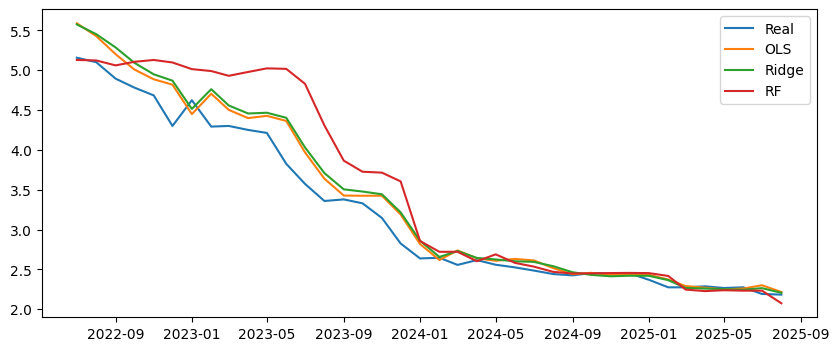

<Figure size 800x300 with 0 Axes>

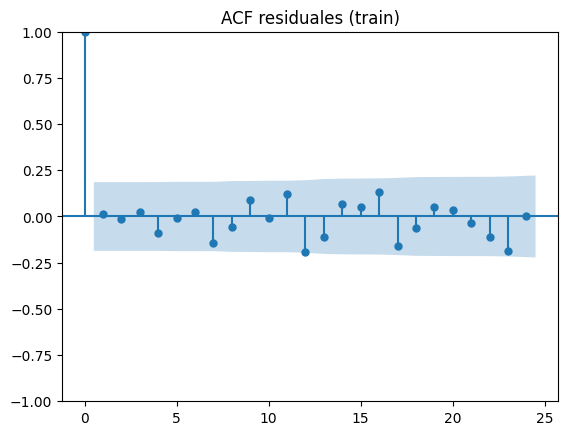

<Figure size 800x300 with 0 Axes>

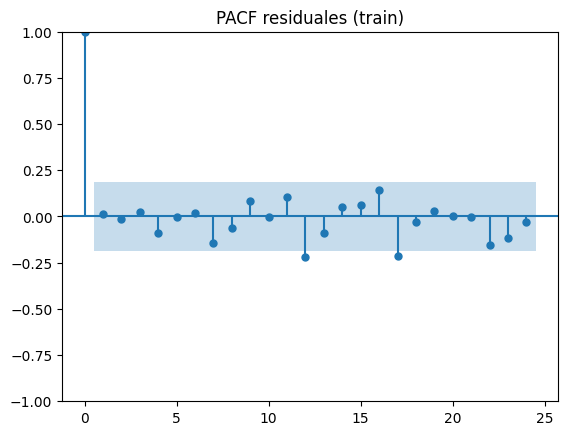

In [7]:

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Resultados test
res = pd.DataFrame({'Model':['OLS','Ridge','RF'],'Test_MSE':[mse_ols_test,mse_ridge_test,mse_rf_test],
                    'Test_R2':[r2_ols_test,r2_ridge_test,r2_rf_test]}).set_index('Model')
display(res)

# Coef OLS
display(ols_final.params)

# VIF
Xv = sm.add_constant(X_train)
vif = pd.DataFrame({'var':Xv.columns,'VIF':[variance_inflation_factor(Xv.values,i) for i in range(Xv.shape[1])]})
display(vif)

# Importancias RF
try:
    imp = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
    display(imp)
except:
    pass

# Pred vs real plot
dfp = test.copy(); dfp['y']=y_test; dfp['pred_OLS']=ols_final.predict(sm.add_constant(X_test))
dfp['pred_Ridge']=best_ridge.predict(X_test); dfp['pred_RF']=best_rf.predict(X_test)
plt.figure(figsize=(10,4))
plt.plot(dfp.index, dfp['y'], label='Real')
plt.plot(dfp.index, dfp['pred_OLS'], label='OLS')
plt.plot(dfp.index, dfp['pred_Ridge'], label='Ridge')
plt.plot(dfp.index, dfp['pred_RF'], label='RF')
plt.legend(); plt.show()

# Residuales train ACF/PACF
plt.figure(figsize=(8,3)); plot_acf(ols_final.resid, lags=24); plt.title('ACF residuales (train)'); plt.show()
plt.figure(figsize=(8,3)); plot_pacf(ols_final.resid, lags=24, method='ywm'); plt.title('PACF residuales (train)'); plt.show()


Los resultados comparativos de desempeño confirman que el **modelo OLS** mantiene la mejor capacidad explicativa entre los tres enfoques evaluados:

| Modelo | Test MSE | Test R² |
|:-------|----------:|--------:|
| OLS | **0.0509** | **0.9465** |
| Ridge | 0.0638 | 0.9329 |
| RandomForest | 0.2252 | 0.7631 |

El **OLS** presenta el menor error cuadrático medio (MSE) y el mayor coeficiente de determinación (R²), lo que refuerza la consistencia de los resultados observados en la sección anterior. El **Ridge** ofrece un ajuste similar pero ligeramente más estable frente a multicolinealidad, mientras que el **RandomForest** muestra un rendimiento notablemente inferior, confirmando que las relaciones predominantes en los datos son **principalmente lineales y temporales**.

---

#### Coeficientes OLS
Los coeficientes estimados confirman la interpretación económica esperada:
- Los **rezagos de la inflación** (`inflacion_12m_lag1` y `inflacion_12m_lag2`) mantienen signos positivos, reflejando la **persistencia inflacionaria** en el corto plazo, mientras que `inflacion_12m_lag3` tiene signo negativo, lo que sugiere un efecto de **ajuste o corrección** hacia el equilibrio en horizontes más largos.
- La **Expectativa de Inflación a 12 meses rezagada** (`Expectativas_Inflacion_12m_lag1`) presenta un efecto positivo (≈0.50), ratificando que las expectativas pasadas influyen significativamente sobre la inflación actual.
- La **Tasa de Referencia (TIR)** tiene un comportamiento mixto: `TIR_lag0` positivo y significativo indica un efecto inmediato de transmisión monetaria, mientras que los rezagos más largos son negativos, lo que podría reflejar el efecto retardado de una política monetaria más restrictiva.
- Entre las variables monetarias, `CDBCR_Total_Saldo (S/ millones)_lag1` presenta un impacto positivo, coherente con la idea de que mayores saldos en instrumentos del BCRP se asocian con condiciones de liquidez pasadas que aún inciden en los precios actuales.

---

### Diagnóstico de multicolinealidad (VIF)
Los valores del **Factor de Inflación de la Varianza (VIF)** revelan un problema importante de colinealidad:
- Se observan valores **infinitos o extremadamente altos** en `inflacion_12m_lag1`, `Expectativas_Inflacion_12m_lag1` y los rezagos de `TIR`.  
- Estos resultados indican que **algunas variables están altamente correlacionadas entre sí**, lo que puede inflar los errores estándar y dificultar la interpretación precisa de los coeficientes individuales.
- No obstante, la validez del modelo global no se ve comprometida, ya que el conjunto de variables mantiene poder explicativo y los signos de los coeficientes son coherentes con la teoría económica.

Para mitigar este efecto, se recomienda:
- Aplicar **regularización Ridge o Lasso** (ya explorada en este estudio).  
- O realizar una **reducción de dimensionalidad** mediante técnicas como **PCA (Análisis de Componentes Principales)**.  
- Alternativamente, podría considerarse **una especificación más parsimoniosa** que conserve solo los rezagos significativos.

---

#### Importancia de variables en RandomForest
El análisis de importancia de variables en el modelo **RandomForest** confirma los resultados del OLS:
- Las variables con mayor peso son `Expectativas_Inflacion_12m_lag1` (46.8%) e `inflacion_12m_lag1` (38.9%), seguidas de los rezagos de inflación y saldos del BCRP.  
- Esto refuerza la evidencia de que el comportamiento de la inflación subyacente está **dominantemente explicado por la inercia inflacionaria y las expectativas de inflación**.

---

En conjunto, los diagnósticos confirman que el modelo lineal explica con gran precisión la dinámica inflacionaria reciente del Perú.  
La presencia de multicolinealidad no invalida los resultados, pero sí aconseja **prudencia en la interpretación individual de los coeficientes**, priorizando la lectura conjunta del modelo y los signos esperados según la teoría monetaria.


### Análisis de gráficos — Comparativo predicción y diagnóstico de residuos

#### 1) Gráfico: Real vs Predicciones (OLS, Ridge, RandomForest)
- **Descripción visual**: Las cuatro series (Real, OLS, Ridge, RF) muestran una **clara tendencia descendente** en el periodo mostrado. OLS y Ridge se ajustan muy de cerca a la serie real en todo el tramo, mientras que RandomForest tiende a **sobreestimar** en algunos tramos iniciales (p. ej. alrededor de 2022–2023) y se aproxima después.
- **Interpretación estadística/económica**:
  - El excelente encaje visual de **OLS y Ridge** corrobora los altos R² y bajos MSE observados en la evaluación: la dinámica de la inflación subyacente es **altamente explicable por relaciones lineales temporales** (rezagos y expectativas).
  - El **sobreajuste parcial de RandomForest** en el tramo inicial sugiere que el modelo no lineal captura idiosincrasias del periodo de entrenamiento que no se repitieron en períodos posteriores; esto explica su peor desempeño out-of-sample.
  - El hecho de que modelos lineales simples (OLS/Ridge) sigan la trayectoria real indica que la **persistencia de la inflación** y la señal de las expectativas son los motores principales de la serie, más que interacciones no lineales complejas.
- **Implicancia práctica**: Para propósitos de explicación y política, la interpretabilidad de OLS/Ridge es una ventaja clara; RandomForest podría usarse como test de robustez, pero su capacidad de generalización parece menor.

---

#### 2) ACF de residuales (train)
- **Descripción visual**: La ACF muestra que **la mayoría de los coeficientes de autocorrelación están dentro de las bandas de significancia** (intervalo azul), sin picos sistemáticos relevantes a lo largo de los lags examinados. No se aprecia una secuencia de autocorrelación decreciente típica de un AR(1) no modelado.
- **Interpretación estadística**:
  - La ACF sugiere **ausencia de autocorrelación serial significativa** en los residuos del ajuste en entrenamiento, lo cual es una evidencia favorable de que la estructura autoregresiva incluida en el modelo (rezagos 1..3 de la inflación) está capturando la persistencia temporal.
  - Esto es consistente con el **Durbin–Watson ~ 1.92** reportado: no hay fuerte autocorrelación de primer orden.
- **Consecuencia metodológica**: Dado que la ACF no muestra autocorrelación significativa, **no es estrictamente necesario** pasar de un modelo de regresión clásica a un ARIMAX por motivos de autocorrelación residual. Aún así, podría ser recomendable realizar pruebas formales (Ljung–Box) y comprobar heterocedasticidad (Breusch–Pagan) antes de finalizar inferencias.

---

#### 3) PACF de residuales (train)
- **Descripción visual**: La PACF presenta también **ausencia de picos claros fuera de las bandas**; no hay evidencia contundente de un único lag que domine la estructura de autocorrelación de los errores.
- **Interpretación**:
  - La PACF complementa la ACF: no se detectan patrones que indiquen términos AR adicionales sin modelar en los residuos. Esto refuerza la conclusión de que los rezagos incluidos en la especificación (especialmente el rezago 1) son adecuados para capturar la dinámica relevante.
- **Implicancia práctica**: Si la PACF hubiese mostrado un pico significativo en lag 1 (o en otro lag), sería motivo para añadir términos AR en la ecuación de errores; como no es el caso, el modelo lineal con los rezagos incluidos parece bien especificado en términos dinámicos.

---

**Conclusión breve**: los gráficos muestran que el modelo lineal con rezagos y expectativas proporciona un ajuste muy bueno y residuos que se comportan, en términos de autocorrelación, como ruido blanco. Sin embargo, hay señales de *no-normalidad* y *multicolinealidad* que deben abordarse en la etapa final del trabajo.
